In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_data = pd.read_csv("train.csv", engine='python', encoding='utf-8', on_bad_lines='skip')
val_data = pd.read_csv("val.csv", engine='python', encoding='utf-8', on_bad_lines='skip')
test_data = pd.read_csv("test.csv", engine='python', encoding='utf-8', on_bad_lines='skip')

train_data['body_length'] = train_data['body'].astype(str).apply(len)
val_data['body_length'] = val_data['body'].astype(str).apply(len)
test_data['body_length'] = test_data['body'].astype(str).apply(len)

train_data['created_utc'] = pd.to_datetime(train_data['created_utc'], unit='s')
val_data['created_utc'] = pd.to_datetime(val_data['created_utc'], unit='s')
test_data['created_utc'] = pd.to_datetime(test_data['created_utc'], unit='s')

train_data['post_hour'] = train_data['created_utc'].dt.hour
val_data['post_hour'] = val_data['created_utc'].dt.hour
test_data['post_hour'] = test_data['created_utc'].dt.hour

features = ['ups', 'downs', 'body_length', 'post_hour']
target = 'score'  # Assuming 'score' is the popularity target

X_train = train_data[features]
y_train = train_data[target]

X_val = val_data[features]
y_val = val_data[target]

X_test = test_data[features]
y_test = test_data[target]

for col in features:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

y_train = pd.to_numeric(y_train, errors='coerce')
y_val = pd.to_numeric(y_val, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# Fill missing values with mean
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean())
X_test = X_test.fillna(X_test.mean())

y_train = y_train.fillna(y_train.mean())
y_val = y_val.fillna(y_val.mean())
y_test = y_test.fillna(y_test.mean())

def add_engineered_features(df):
    df = df.copy()
    df['ups_downs_product'] = df['ups'] * df['downs']
    df['ups_squared'] = df['ups'] ** 2
    df['body_hour_interaction'] = df['body_length'] * df['post_hour']
    
    # Log transform only non-negative numbers
    df['ups_log'] = np.log1p(df['ups'].clip(lower=0))
    df['downs_log'] = np.log1p(df['downs'].clip(lower=0))
    
    # Safely compute ups_to_downs
    df['ups_to_downs'] = df['ups'] / (df['downs'] + 1)
    
    # Replace any remaining infinities or NaNs with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

X_train_enhanced = add_engineered_features(X_train)
X_val_enhanced = add_engineered_features(X_val)
X_test_enhanced = add_engineered_features(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
}



C:\Users\DEESHA\AppData\Local\Temp\ipykernel_26388\3372687237.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
C:\Users\DEESHA\AppData\Local\Temp\ipykernel_26388\3372687237.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
C:\Users\DEESHA\AppData\Local\Temp\ipykernel_26388\3372687237.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [ ]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_enhanced)
X_val_scaled = scaler_X.transform(X_val_enhanced)
X_test_scaled = scaler_X.transform(X_test_enhanced)

# Keep y in original scale (no scaling)
y_train_orig = y_train.values
y_val_orig = y_val.values
y_test_orig = y_test.values

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
}

results_val = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_orig)
    preds_val = model.predict(X_val_scaled)
    
    mse_val = mean_squared_error(y_val_orig, preds_val)
    mae_val = mean_absolute_error(y_val_orig, preds_val)
    
    results_val.append({"Model": name, "MSE": mse_val, "MAE": mae_val})
    
    print(f"✅ {name} Trained Successfully on validation set")
    print(f"   MSE: {mse_val:.4f}, MAE: {mae_val:.4f}\n")

results_test = []

for name, model in models.items():
    preds_test = model.predict(X_test_scaled)
    
    mse_test = mean_squared_error(y_test_orig, preds_test)
    mae_test = mean_absolute_error(y_test_orig, preds_test)
    
    results_test.append({"Model": name, "MSE": mse_test, "MAE": mae_test})
    
    print(f"📌 {name} Test Set Performance")
    print(f"   MSE: {mse_test:.4f}, MAE: {mae_test:.4f}\n")

results_val_df = pd.DataFrame(results_val)
print("📊 Model Comparison (Validation Set):")
print(results_val_df.sort_values("MSE"))

results_test_df = pd.DataFrame(results_test)
print("📊 Model Comparison (Test Set):")
print(results_test_df.sort_values("MSE"))


✅ Linear Regression Trained Successfully on validation set
   MSE: 705.9663, MAE: 7.1325

✅ Random Forest Trained Successfully on validation set
   MSE: 2.5216, MAE: 0.0134

✅ Gradient Boosting Trained Successfully on validation set
   MSE: 4.1768, MAE: 0.0150

📌 Linear Regression Test Set Performance
   MSE: 722.2835, MAE: 7.1656

📌 Random Forest Test Set Performance
   MSE: 0.5490, MAE: 0.0101

📌 Gradient Boosting Test Set Performance
   MSE: 1.2344, MAE: 0.0120

📊 Model Comparison (Validation Set):
               Model         MSE       MAE
1      Random Forest    2.521619  0.013446
2  Gradient Boosting    4.176755  0.015016
0  Linear Regression  705.966326  7.132534
📊 Model Comparison (Test Set):
               Model         MSE       MAE
1      Random Forest    0.549006  0.010081
2  Gradient Boosting    1.234395  0.012001
0  Linear Regression  722.283482  7.165586


Top 10 features contributing to post popularity:
ups_to_downs             0.295862
ups                      0.283313
ups_log                  0.263318
ups_squared              0.156037
body_length              0.000931
body_hour_interaction    0.000423
post_hour                0.000116
downs                    0.000000
ups_downs_product        0.000000
downs_log                0.000000
dtype: float64


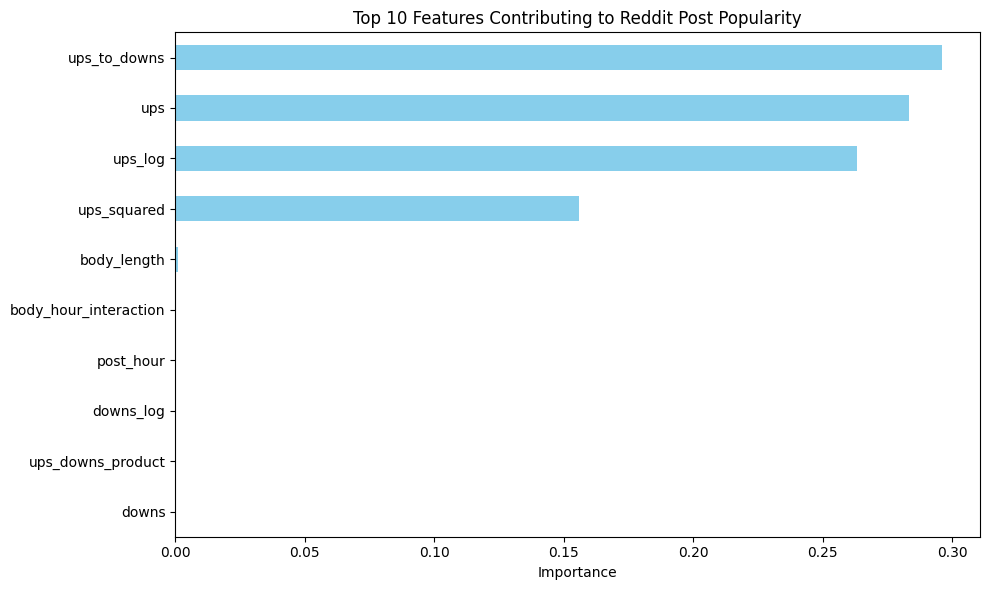

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
rf.fit(X_train_enhanced, y_train)  # Use unscaled target

feat_importance = pd.Series(rf.feature_importances_, index=X_train_enhanced.columns).sort_values(ascending=False)

print("Top 10 features contributing to post popularity:")
print(feat_importance.head(10))

plt.figure(figsize=(10,6))
feat_importance.head(10).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 10 Features Contributing to Reddit Post Popularity")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
